# Exploring Dandiset 001433: Breathing rhythm and place dataset

**Note:** This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results and verify any findings independently.

## Overview

This Dandiset contains behavioral and electrophysiological data from recordings of sniffing, video, and olfactory bulb (OB) electrophysiology in freely-behaving mice. The recordings were conducted in the absence of any stimulus, reward, or specific task.

**Dandiset Link:** https://dandiarchive.org/dandiset/001433/0.250507.2356

**Key Features:**
- Species: Mus musculus (House mouse)
- 4 subjects with 27 recording sessions total
- Multi-electrode extracellular electrophysiology from olfactory bulb
- Synchronized sniffing behavior recordings
- Data volume: ~41.4 GB
- Funded by: NIH grant 1 R01 NS 123903-03

## Required Packages

This notebook requires the following packages (assumed to be already installed):
- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `numpy`
- `matplotlib`
- `pandas`

## Exploring the Dandiset with DANDI API

In [1]:
from dandi.dandiapi import DandiAPIClient

# Get basic information about the dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset("001433", "0.250507.2356")
metadata = dandiset.get_raw_metadata()

print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description']}")

Dandiset name: Breathing rhythm and place dataset
Dandiset URL: https://dandiarchive.org/dandiset/001433/0.250507.2356
Description: These are behavioral and electrophysiological data from recordings of sniffing, video, and OB electrophysiology in freely-behaving mice given no stimulus, reward, or task. 1 1 R01 NS 123903


## Exploring NWB Files in the Dandiset

In [2]:
from collections import defaultdict
import pandas as pd

# List all .nwb files in the Dandiset
assets = list(dandiset.get_assets_by_glob("*.nwb"))

print(f"Total number of NWB files: {len(assets)}")
print(f"Total data volume: {sum(asset.size for asset in assets) / 1e9:.1f} GB")
print("\nFile organization:")

# Parse subject and session info from filenames
sessions = []
by_subject = defaultdict(list)
for asset in assets:
    parts = asset.path.split('/')
    subject_id = parts[0].replace('sub-', '')
    session_timestamp = parts[1].split('_')[2].replace('ses-', '')
    sessions.append({
        'subject_id': subject_id, 
        'session_timestamp': session_timestamp, 
        'path': asset.path, 
        'size_gb': asset.size / 1e9
    })
    by_subject[subject_id].append(session_timestamp)

# Show session counts by subject
for subject, session_list in by_subject.items():
    print(f"  Subject {subject}: {len(session_list)} sessions")

Total number of NWB files: 27
Total data volume: 41.4 GB

File organization:
  Subject 4122: 3 sessions
  Subject 4127: 9 sessions
  Subject 4131: 12 sessions
  Subject 4138: 3 sessions


## Loading and Examining NWB File Structure

Let's examine a representative session file to understand the data structure. We'll use one of the larger files for exploration.

In [3]:
import h5py
import pynwb
import remfile

# Load a representative file (subject 4131, session with substantial data)
file_path = "sub-4131/sub-4131_ses-20250507T153417_ecephys.nwb"
asset = next(dandiset.get_assets_by_glob(file_path))

# Stream the file remotely (no download required)
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

print(f"Session description: {nwb.session_description}")
print(f"Session identifier: {nwb.identifier}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Institution: {nwb.institution}")
print(f"Experimenter: {nwb.experimenter}")

Session description: LFP and sniff recording
Session identifier: 4131_17
Subject ID: 4131
Institution: University of Oregon
Experimenter: ('Rafilson, Sidney',)


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Data Acquisition Components

In [4]:
print("Available acquisition data:")
for name, data in nwb.acquisition.items():
    print(f"  {name}: {type(data).__name__}")
    if hasattr(data, 'data') and hasattr(data.data, 'shape'):
        print(f"    Shape: {data.data.shape}")
        print(f"    Sampling rate: {data.rate} Hz")
        print(f"    Description: {data.description}")

Available acquisition data:
  LFP: ElectricalSeries
    Shape: (7046400, 64)
    Sampling rate: 1000.0 Hz
    Description: LFP signal from olfactory bulb
  SniffSignal: TimeSeries
    Shape: (7046400,)
    Sampling rate: 1000.0 Hz
    Description: Raw sniff thermistor voltage


### Processing Modules (Behavioral Events)

In [5]:
print("Processing modules:")
for name, module in nwb.processing.items():
    print(f"  {name}: {module.description}")
    for interface_name, interface in module.data_interfaces.items():
        print(f"    {interface_name}: {type(interface).__name__}")
        if hasattr(interface, 'data') and hasattr(interface.data, 'shape'):
            print(f"      Data shape: {interface.data.shape}")

Processing modules:
  behavior: Sniff event features
    exhalation_time: TimeSeries
      Data shape: (28475,)
    inhalation_time: TimeSeries
      Data shape: (28475,)


### Electrode Information

In [6]:
# Examine electrode metadata
electrode_df = nwb.electrodes.to_dataframe()
print(f"Number of electrodes: {len(electrode_df)}")
print(f"Electrode locations: {electrode_df['location'].unique()}")
print(f"Electrode groups: {electrode_df['group_name'].unique()}")
print(f"Filtering: {electrode_df['filtering'].unique()}")

print("\nFirst 5 electrodes:")
print(electrode_df.head())

Number of electrodes: 64
Electrode locations: ['olfactory bulb']
Electrode groups: ['LFPGroup']
Filtering: ['none']

First 5 electrodes:
          location                                              group  \
id                                                                      
0   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x136...   
1   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x136...   
2   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x136...   
3   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x136...   
4   olfactory bulb  LFPGroup pynwb.ecephys.ElectrodeGroup at 0x136...   

   group_name filtering  
id                       
0    LFPGroup      none  
1    LFPGroup      none  
2    LFPGroup      none  
3    LFPGroup      none  
4    LFPGroup      none  


## Visualizing Key Data Modalities

**Important Note:** There is a known issue with breathing event times in this dataset. The event times are stored in the `.timestamps` arrays and are in milliseconds (not seconds as might be expected). The `.data` arrays contain placeholder values (all 1's) and should not be used for timing analysis.

### LFP and Sniffing Signal Overview

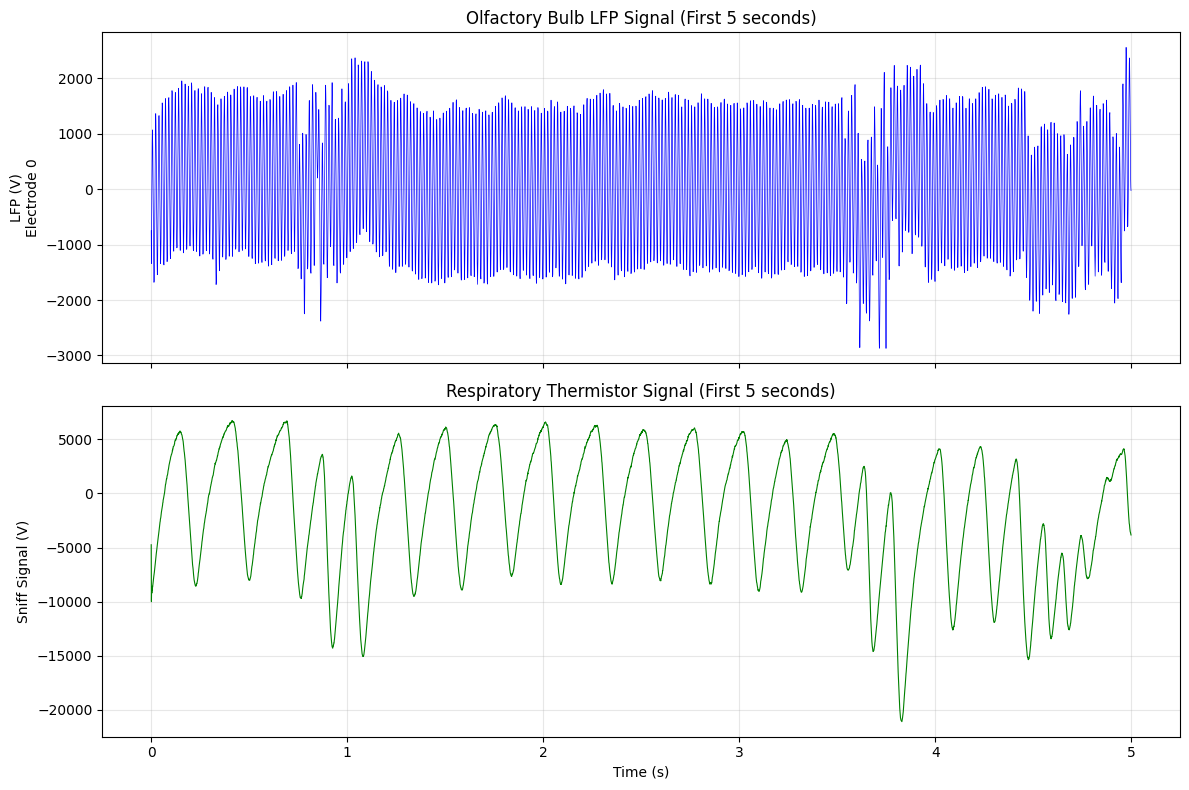

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Extract LFP and sniffing data for visualization
lfp = nwb.acquisition['LFP']
sniff = nwb.acquisition['SniffSignal']

# Get a 5-second segment for initial exploration
rate = int(lfp.rate)
segment_duration = 5  # seconds
lfp_segment = lfp.data[:rate * segment_duration, 0]  # First channel only
sniff_segment = sniff.data[:rate * segment_duration]
time_vector = np.arange(len(lfp_segment)) / rate

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot LFP from electrode 0
ax1.plot(time_vector, lfp_segment, color='blue', linewidth=0.5)
ax1.set_ylabel('LFP (V)\nElectrode 0')
ax1.set_title('Olfactory Bulb LFP Signal (First 5 seconds)')
ax1.grid(True, alpha=0.3)

# Plot sniffing signal
ax2.plot(time_vector, sniff_segment, color='green', linewidth=0.8)
ax2.set_ylabel('Sniff Signal (V)')
ax2.set_xlabel('Time (s)')
ax2.set_title('Respiratory Thermistor Signal (First 5 seconds)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Multi-Channel LFP Visualization

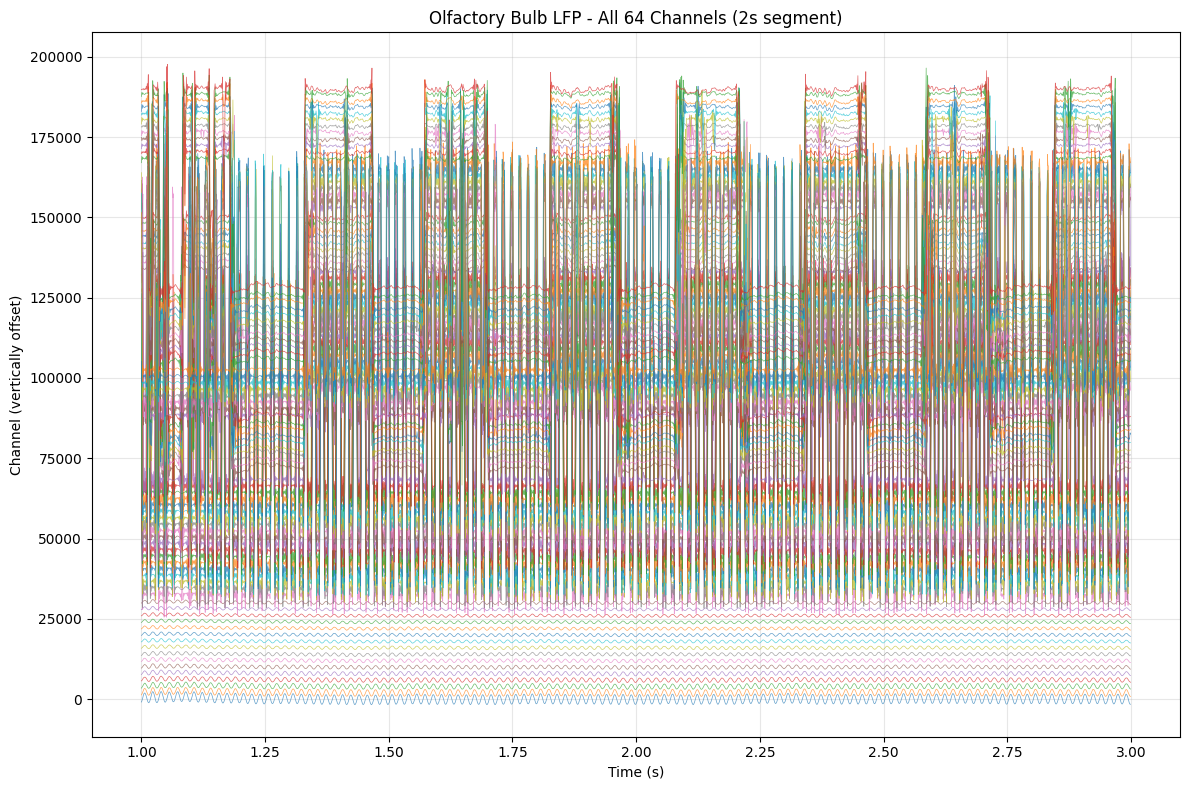

LFP signal statistics (first 5 channels):
  Channel  0: mean=60.49V, std=1092.31V
  Channel  1: mean=40.99V, std=749.30V
  Channel  2: mean=29.69V, std=577.03V
  Channel  3: mean=29.58V, std=492.01V
  Channel  4: mean=18.21V, std=454.91V


In [8]:
# Visualize all 64 LFP channels simultaneously (2-second segment)
segment_2s = rate * 2
start_time = rate * 1  # Start at 1 second
lfp_multichannel = lfp.data[start_time:start_time + segment_2s, :]
time_2s = np.arange(lfp_multichannel.shape[0]) / rate + 1

plt.figure(figsize=(12, 8))
# Plot all channels with vertical offset for visualization
offset = 2000  # Voltage offset between channels
for ch in range(lfp_multichannel.shape[1]):
    plt.plot(time_2s, lfp_multichannel[:, ch] + ch * offset, 
             alpha=0.7, linewidth=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Channel (vertically offset)')
plt.title('Olfactory Bulb LFP - All 64 Channels (2s segment)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display basic statistics for first few channels
print("LFP signal statistics (first 5 channels):")
for i in range(5):
    mean_val = np.mean(lfp_multichannel[:, i])
    std_val = np.std(lfp_multichannel[:, i])
    print(f"  Channel {i:2d}: mean={mean_val:.2f}V, std={std_val:.2f}V")

### Breathing Events and Respiratory Rhythm

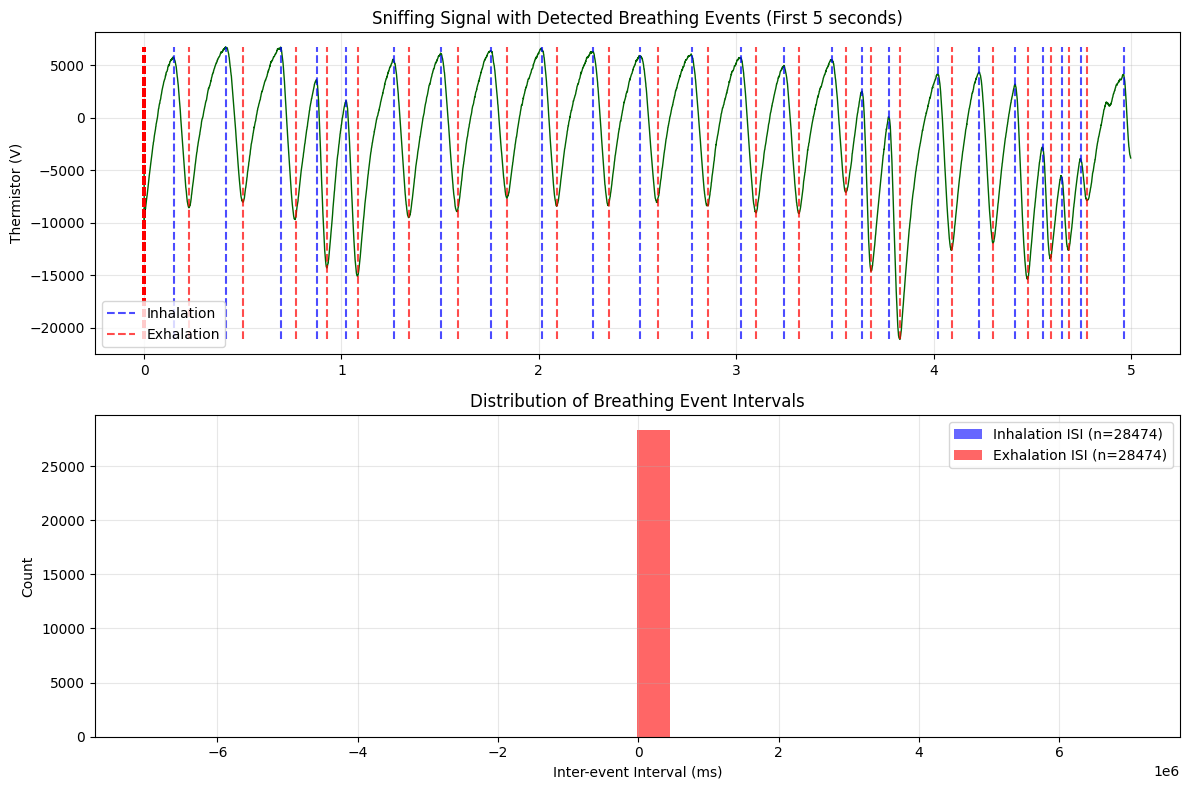

Breathing rhythm statistics:
  Total inhalation events: 28475
  Total exhalation events: 28475
  Mean inhalation interval: 247.4 ms
  Mean exhalation interval: -0.0 ms


In [9]:
# Extract breathing event timestamps (CRITICAL: these are in milliseconds!)
inh_timestamps_ms = nwb.processing['behavior'].data_interfaces['inhalation_time'].timestamps[:]
exh_timestamps_ms = nwb.processing['behavior'].data_interfaces['exhalation_time'].timestamps[:]

# Convert to seconds for plotting with sniff signal
inh_timestamps_s = inh_timestamps_ms / 1000.0
exh_timestamps_s = exh_timestamps_ms / 1000.0

# Select events within first 5 seconds for visualization
inh_events_5s = inh_timestamps_s[inh_timestamps_s <= 5]
exh_events_5s = exh_timestamps_s[exh_timestamps_s <= 5]

# Calculate inter-event intervals for rhythm analysis
inh_intervals_ms = np.diff(inh_timestamps_ms)
exh_intervals_ms = np.diff(exh_timestamps_ms)

# Create breathing analysis visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Top: Sniff signal with event markers
ax1.plot(time_vector, sniff_segment, color='darkgreen', linewidth=1)
ax1.vlines(inh_events_5s, ymin=np.min(sniff_segment), ymax=np.max(sniff_segment), 
           colors='blue', linestyles='dashed', alpha=0.7, label='Inhalation')
ax1.vlines(exh_events_5s, ymin=np.min(sniff_segment), ymax=np.max(sniff_segment), 
           colors='red', linestyles='dashed', alpha=0.7, label='Exhalation')
ax1.set_ylabel('Thermistor (V)')
ax1.set_title('Sniffing Signal with Detected Breathing Events (First 5 seconds)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Inter-event interval distribution
ax2.hist(inh_intervals_ms, bins=30, alpha=0.6, color='blue', 
         label=f'Inhalation ISI (n={len(inh_intervals_ms)})')
ax2.hist(exh_intervals_ms, bins=30, alpha=0.6, color='red', 
         label=f'Exhalation ISI (n={len(exh_intervals_ms)})')
ax2.set_xlabel('Inter-event Interval (ms)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Breathing Event Intervals')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print breathing rhythm statistics
print("Breathing rhythm statistics:")
print(f"  Total inhalation events: {len(inh_timestamps_ms)}")
print(f"  Total exhalation events: {len(exh_timestamps_ms)}")
print(f"  Mean inhalation interval: {np.mean(inh_intervals_ms):.1f} ms")
print(f"  Mean exhalation interval: {np.mean(exh_intervals_ms):.1f} ms")

## Practical Code for Data Access

Here are reusable code snippets for accessing different data types:

In [10]:
def load_nwb_file(subject_id, session_timestamp=None):
    """
    Load an NWB file for a given subject and optionally specific session.
    If session_timestamp is None, loads the first available session.
    """
    if session_timestamp:
        pattern = f"sub-{subject_id}/sub-{subject_id}_ses-{session_timestamp}_ecephys.nwb"
    else:
        pattern = f"sub-{subject_id}/*.nwb"
    
    asset = next(dandiset.get_assets_by_glob(pattern))
    remote_file = remfile.File(asset.download_url)
    h5_file = h5py.File(remote_file)
    io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
    return io.read()

def get_lfp_data(nwb_file, channels=None, time_range=None):
    """Extract LFP data with optional channel and time selection."""
    lfp = nwb_file.acquisition['LFP']
    if time_range:
        start_idx = int(time_range[0] * lfp.rate)
        end_idx = int(time_range[1] * lfp.rate)
        data = lfp.data[start_idx:end_idx, :]
    else:
        data = lfp.data[:]
    
    if channels:
        data = data[:, channels]
    
    return data, lfp.rate

def get_breathing_events(nwb_file):
    """Extract breathing event timestamps (converted to seconds)."""
    behavior = nwb_file.processing['behavior'].data_interfaces
    inh_times_s = behavior['inhalation_time'].timestamps[:] / 1000.0
    exh_times_s = behavior['exhalation_time'].timestamps[:] / 1000.0
    return inh_times_s, exh_times_s

# Example usage
print("Example: Loading data from subject 4127")
nwb_example = load_nwb_file("4127")
lfp_data, rate = get_lfp_data(nwb_example, channels=[0, 1], time_range=[0, 2])
inh_times, exh_times = get_breathing_events(nwb_example)

print(f"LFP data shape: {lfp_data.shape} (time x channels)")
print(f"Sampling rate: {rate} Hz")
print(f"Number of breathing events: {len(inh_times)} inhalations, {len(exh_times)} exhalations")

Example: Loading data from subject 4127


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


LFP data shape: (2000, 2) (time x channels)
Sampling rate: 1000.0 Hz
Number of breathing events: 20844 inhalations, 20844 exhalations


## Summary and Next Steps

This notebook demonstrates how to:
- Access and explore the structure of Dandiset 001433
- Load NWB files containing olfactory bulb LFP and respiratory data
- Visualize multi-channel electrophysiology alongside behavioral signals
- Correctly interpret breathing event timestamps (in milliseconds)
- Extract and analyze respiratory rhythm patterns

The dataset provides rich opportunities for investigating:
- Neural-respiratory coupling in the olfactory bulb
- Cross-animal and cross-session variability in breathing patterns
- Spectral analysis of LFP signals in relation to respiratory phase
- Spatial patterns of activity across the electrode array

**Key Technical Notes:**
- Breathing event times are stored in `.timestamps` arrays in milliseconds
- LFP data is sampled at 1000 Hz with 64 channels per session
- All data can be streamed remotely without local downloads
- Files are organized by subject and session for systematic analysis